## Read data

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import pickle
from collections import OrderedDict
import copy
from scipy.sparse import csr_matrix
from scipy import io
import seaborn as sns
import joblib
from base import *
from joblib import Parallel, delayed
import random
import scipy as sc
import sys

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

### Read raw speed and count data

In [3]:
# start_month=int(sys.argv[1])
# start_day=int(sys.argv[2])
# end_month=int(sys.argv[3])
# end_day=int(sys.argv[4])
# year =int(sys.argv[5])
# flag_weekday = int(sys.argv[6])

#2020-06-26 - 2020-07-06

start_month=3
start_day=20
end_month=3
end_day=20
year =2019
flag_weekday = 1

In [4]:
read_in_folder = './Processed_data/20190320_large/'
write_folder = './Numerical_result/06_22_2022_NumericalResult/'
# read_in_folder = './network_decompose/small_network/network_testcases/network_sm/'
# os.chdir('./network_testcases/network_sm/')

with open(read_in_folder+'volume_dict_link_4.pkl', 'rb') as handle:
    count_data = pickle.load(handle)
with open(read_in_folder+'speed_dict_link_4.pkl', 'rb') as handle:
    spd_data = pickle.load(handle)
    
print(spd_data)

{0: time        00:00:00  00:05:00  00:10:00  00:15:00  00:20:00  00:25:00  \
date                                                                     
2019-03-20      66.1      65.5      66.4      64.7      64.7      65.2   

time        00:30:00  00:35:00  00:40:00  00:45:00  ...  23:10:00  23:15:00  \
date                                                ...                       
2019-03-20      65.4      65.3      65.0      66.5  ...      65.7      65.4   

time        23:20:00  23:25:00  23:30:00  23:35:00  23:40:00  23:45:00  \
date                                                                     
2019-03-20      65.9      66.1      67.7      66.5      66.1      65.8   

time        23:50:00  23:55:00  
date                            
2019-03-20      66.2      66.2  

[1 rows x 288 columns], 1: time        00:00:00  00:05:00  00:10:00  00:15:00  00:20:00  00:25:00  \
date                                                                     
2019-03-20      72.3      72.2      7

### Read graph data

In [5]:
with open(read_in_folder+'od_list.pickle', 'rb') as handle:
    (O_list, D_list) = pickle.load(handle)
# with open('graph.pickle', 'rb') as handle:
#     G = pickle.load(handle)
G = nx.read_gpickle(read_in_folder+'graph_4.pickle')

# with open(read_in_folder+'od_list_4.pickle', 'rb') as handle:
#     pickle.dump((O_list, D_list),handle, protocol=4)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]


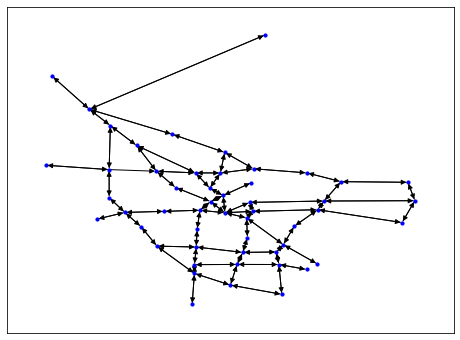

In [6]:
with open(read_in_folder+'od_list.pickle', 'rb') as handle:
    (O_list, D_list) = pickle.load(handle)
# with open('graph.pickle', 'rb') as handle:
#     G = pickle.load(handle)
G = nx.read_gpickle(read_in_folder+'graph_4.pickle')
G = nx.freeze(G)
# print(O_list)
pos=nx.get_node_attributes(G,'pos')
plt.rcParams['figure.figsize'] = [8, 6]
nx.draw_networkx(G,pos,node_size=10,node_color='blue',with_labels=False)
# print(G.number_of_edges())
# print(G.number_of_nodes())
Node = list(G.nodes)
Node.sort()
# print("Nodes: ", Node)

print(O_list)


## Interpolate the data

for name in count_data.keys():
    count_data[name] = count_data[name].replace(0.0, np.nan)
    count_data[name] = count_data[name].interpolate(method='linear', axis=0)
    count_data[name] = count_data[name].interpolate(method='linear', axis=1)
    count_data[name] = count_data[name].fillna(value = count_data[name].mean().mean())
    print(name,", ",count_data[name])
for name in spd_data.keys():
    spd_data[name] = spd_data[name].replace(0.0, np.nan)
    spd_data[name] = spd_data[name].interpolate(method='linear', axis=0)
    spd_data[name] = spd_data[name].interpolate(method='linear', axis=1)
    spd_data[name] = spd_data[name].fillna(value = spd_data[name].mean().mean())

## Set Parameters

In [7]:
#no > flag_weekday1 & no < flag_weekday2:
if flag_weekday == 1:
    flag_weekday1 = -1
    flag_weekday2 = 5
else:
    flag_weekday1 = 4
    flag_weekday2 = 7

start_date = datetime.date(year, start_month, start_day)
end_date = datetime.date(year, end_month, end_day)
delta_date = datetime.timedelta(days = 1)
time_basis = datetime.time(0,0,0)
N_path = 1
time_interval_min = 6*60

## Enuerate all paths
todo: 
1. based on the network, select k shortest path
algorithm:
1. find all path
2. order the path by length
3. take the first k shortest path

In [8]:
from itertools import islice
def k_shortest_paths(G, source, target, k, weight=None):
    def path_cost(G, path):
        return sum([G[path[i]][path[i+1]]['length'] for i in range(len(path)-1)])
    p = list(islice(nx.shortest_simple_paths(G, source, target, weight=weight), k))
    #print('p',p)
#     if(len(p) < k) or (len(p[k-1]) <= 0):
#         return (float('inf'), [])
#     else:
#         return [path_cost(G,p[k-1]), p[k-1]]
    return p

#print(k_shortest_paths(G,737184,718421,1,weight='length'))

In [9]:
OD_paths = OrderedDict()
link_dict = OrderedDict()
path_list = list()
# O_list = O_list[:]
# D_list = D_list[:]
shortest_path_list = list()
count = 0;
k=1
N_path = 1
# while len(shortest_path_list) < N_path:
OD_list_output = []
print(O_list)
for O in O_list:
    for D in O_list:
        print(O, D);
        if O!=D:
            try:
                paths = k_shortest_paths(G,O, D,N_path,weight='length') #My code
                if len(paths) != 0:
                    tmp_path_list = list()
                    for path in paths:
                        path_o = Path()
                        path_o.node_list = path
                        path_o.node_to_list(G, link_dict)
                        tmp_path_list.append(path_o)
                        path_list.append(path_o)
                        
                    OD_paths[(O, D)] = tmp_path_list
                    shortest_path_list.append(paths)
                    OD_list_output.append([O,D])
                    print("From ", O, " To ", D, "there are ", k, "paths")
                else:
                    pass
            except:
#                     print("From ", O, " To ", D, "there are no paths")
                pass
        else:
#                 print("From ", O, " To ", D, "same")
            pass
np.savetxt('path_'+start_date.strftime("%m_%d_%Y")+'_'+\
           str(time_interval_min)+'.txt', OD_list_output, delimiter = ',',fmt='%s')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
0 0
0 1
From  0  To  1 there are  1 paths
0 2
From  0  To  2 there are  1 paths
0 3
From  0  To  3 there are  1 paths
0 4
From  0  To  4 there are  1 paths
0 5
From  0  To  5 there are  1 paths
0 6
From  0  To  6 there are  1 paths
0 7
From  0  To  7 there are  1 paths
0 8
From  0  To  8 there are  1 paths
0 9
From  0  To  9 there are  1 paths
0 10
From  0  To  10 there are  1 paths
0 11
From  0  To  11 there are  1 paths
0 12
From  0  To  12 there are  1 paths
0 13
From  0  To  13 there are  1 paths
0 14
From  0  To  14 there are  1 paths
0 15
From  0  To  15 there are  1 paths
0 16
From  0  To  16 there are  1 paths
0 17
From  0  To  17 there are  1 paths
0 18
From  0  To  18 there are  1 paths
0 19
From  0  To  19 there are  1 paths
0 20
From  0  To  20 there are  1 paths
0 21
From  0  T

From  4  To  29 there are  1 paths
4 30
From  4  To  30 there are  1 paths
4 31
From  4  To  31 there are  1 paths
4 32
From  4  To  32 there are  1 paths
4 33
From  4  To  33 there are  1 paths
4 34
From  4  To  34 there are  1 paths
4 35
From  4  To  35 there are  1 paths
4 36
From  4  To  36 there are  1 paths
4 37
From  4  To  37 there are  1 paths
4 38
From  4  To  38 there are  1 paths
4 39
From  4  To  39 there are  1 paths
4 40
From  4  To  40 there are  1 paths
4 41
From  4  To  41 there are  1 paths
4 42
From  4  To  42 there are  1 paths
4 43
From  4  To  43 there are  1 paths
4 44
From  4  To  44 there are  1 paths
4 45
From  4  To  45 there are  1 paths
4 46
From  4  To  46 there are  1 paths
4 47
From  4  To  47 there are  1 paths
4 48
From  4  To  48 there are  1 paths
4 49
From  4  To  49 there are  1 paths
4 50
From  4  To  50 there are  1 paths
4 51
From  4  To  51 there are  1 paths
5 0
From  5  To  0 there are  1 paths
5 1
From  5  To  1 there are  1 paths
5 2
From 

From  12  To  44 there are  1 paths
12 45
From  12  To  45 there are  1 paths
12 46
From  12  To  46 there are  1 paths
12 47
From  12  To  47 there are  1 paths
12 48
From  12  To  48 there are  1 paths
12 49
From  12  To  49 there are  1 paths
12 50
From  12  To  50 there are  1 paths
12 51
From  12  To  51 there are  1 paths
13 0
From  13  To  0 there are  1 paths
13 1
From  13  To  1 there are  1 paths
13 2
From  13  To  2 there are  1 paths
13 3
From  13  To  3 there are  1 paths
13 4
From  13  To  4 there are  1 paths
13 5
From  13  To  5 there are  1 paths
13 6
From  13  To  6 there are  1 paths
13 7
From  13  To  7 there are  1 paths
13 8
From  13  To  8 there are  1 paths
13 9
From  13  To  9 there are  1 paths
13 10
From  13  To  10 there are  1 paths
13 11
From  13  To  11 there are  1 paths
13 12
From  13  To  12 there are  1 paths
13 13
13 14
From  13  To  14 there are  1 paths
13 15
From  13  To  15 there are  1 paths
13 16
From  13  To  16 there are  1 paths
13 17
From  

From  17  To  42 there are  1 paths
17 43
From  17  To  43 there are  1 paths
17 44
From  17  To  44 there are  1 paths
17 45
From  17  To  45 there are  1 paths
17 46
From  17  To  46 there are  1 paths
17 47
From  17  To  47 there are  1 paths
17 48
From  17  To  48 there are  1 paths
17 49
From  17  To  49 there are  1 paths
17 50
From  17  To  50 there are  1 paths
17 51
From  17  To  51 there are  1 paths
18 0
From  18  To  0 there are  1 paths
18 1
From  18  To  1 there are  1 paths
18 2
From  18  To  2 there are  1 paths
18 3
From  18  To  3 there are  1 paths
18 4
From  18  To  4 there are  1 paths
18 5
From  18  To  5 there are  1 paths
18 6
From  18  To  6 there are  1 paths
18 7
From  18  To  7 there are  1 paths
18 8
From  18  To  8 there are  1 paths
18 9
From  18  To  9 there are  1 paths
18 10
From  18  To  10 there are  1 paths
18 11
From  18  To  11 there are  1 paths
18 12
From  18  To  12 there are  1 paths
18 13
From  18  To  13 there are  1 paths
18 14
From  18  To

From  22  To  32 there are  1 paths
22 33
From  22  To  33 there are  1 paths
22 34
From  22  To  34 there are  1 paths
22 35
From  22  To  35 there are  1 paths
22 36
From  22  To  36 there are  1 paths
22 37
From  22  To  37 there are  1 paths
22 38
From  22  To  38 there are  1 paths
22 39
From  22  To  39 there are  1 paths
22 40
From  22  To  40 there are  1 paths
22 41
From  22  To  41 there are  1 paths
22 42
From  22  To  42 there are  1 paths
22 43
From  22  To  43 there are  1 paths
22 44
From  22  To  44 there are  1 paths
22 45
From  22  To  45 there are  1 paths
22 46
From  22  To  46 there are  1 paths
22 47
From  22  To  47 there are  1 paths
22 48
From  22  To  48 there are  1 paths
22 49
From  22  To  49 there are  1 paths
22 50
From  22  To  50 there are  1 paths
22 51
From  22  To  51 there are  1 paths
23 0
From  23  To  0 there are  1 paths
23 1
From  23  To  1 there are  1 paths
23 2
From  23  To  2 there are  1 paths
23 3
From  23  To  3 there are  1 paths
23 4
F

28 2
From  28  To  2 there are  1 paths
28 3
From  28  To  3 there are  1 paths
28 4
From  28  To  4 there are  1 paths
28 5
From  28  To  5 there are  1 paths
28 6
From  28  To  6 there are  1 paths
28 7
From  28  To  7 there are  1 paths
28 8
From  28  To  8 there are  1 paths
28 9
From  28  To  9 there are  1 paths
28 10
From  28  To  10 there are  1 paths
28 11
From  28  To  11 there are  1 paths
28 12
From  28  To  12 there are  1 paths
28 13
From  28  To  13 there are  1 paths
28 14
From  28  To  14 there are  1 paths
28 15
From  28  To  15 there are  1 paths
28 16
From  28  To  16 there are  1 paths
28 17
From  28  To  17 there are  1 paths
28 18
From  28  To  18 there are  1 paths
28 19
From  28  To  19 there are  1 paths
28 20
From  28  To  20 there are  1 paths
28 21
From  28  To  21 there are  1 paths
28 22
From  28  To  22 there are  1 paths
28 23
From  28  To  23 there are  1 paths
28 24
From  28  To  24 there are  1 paths
28 25
From  28  To  25 there are  1 paths
28 26
Fr

From  33  To  23 there are  1 paths
33 24
From  33  To  24 there are  1 paths
33 25
From  33  To  25 there are  1 paths
33 26
From  33  To  26 there are  1 paths
33 27
From  33  To  27 there are  1 paths
33 28
From  33  To  28 there are  1 paths
33 29
From  33  To  29 there are  1 paths
33 30
From  33  To  30 there are  1 paths
33 31
From  33  To  31 there are  1 paths
33 32
From  33  To  32 there are  1 paths
33 33
33 34
From  33  To  34 there are  1 paths
33 35
From  33  To  35 there are  1 paths
33 36
From  33  To  36 there are  1 paths
33 37
From  33  To  37 there are  1 paths
33 38
From  33  To  38 there are  1 paths
33 39
From  33  To  39 there are  1 paths
33 40
From  33  To  40 there are  1 paths
33 41
From  33  To  41 there are  1 paths
33 42
From  33  To  42 there are  1 paths
33 43
From  33  To  43 there are  1 paths
33 44
From  33  To  44 there are  1 paths
33 45
From  33  To  45 there are  1 paths
33 46
From  33  To  46 there are  1 paths
33 47
From  33  To  47 there are  

38 46
From  38  To  46 there are  1 paths
38 47
From  38  To  47 there are  1 paths
38 48
From  38  To  48 there are  1 paths
38 49
From  38  To  49 there are  1 paths
38 50
From  38  To  50 there are  1 paths
38 51
From  38  To  51 there are  1 paths
39 0
From  39  To  0 there are  1 paths
39 1
From  39  To  1 there are  1 paths
39 2
From  39  To  2 there are  1 paths
39 3
From  39  To  3 there are  1 paths
39 4
From  39  To  4 there are  1 paths
39 5
From  39  To  5 there are  1 paths
39 6
From  39  To  6 there are  1 paths
39 7
From  39  To  7 there are  1 paths
39 8
From  39  To  8 there are  1 paths
39 9
From  39  To  9 there are  1 paths
39 10
From  39  To  10 there are  1 paths
39 11
From  39  To  11 there are  1 paths
39 12
From  39  To  12 there are  1 paths
39 13
From  39  To  13 there are  1 paths
39 14
From  39  To  14 there are  1 paths
39 15
From  39  To  15 there are  1 paths
39 16
From  39  To  16 there are  1 paths
39 17
From  39  To  17 there are  1 paths
39 18
From  

From  44  To  15 there are  1 paths
44 16
From  44  To  16 there are  1 paths
44 17
From  44  To  17 there are  1 paths
44 18
From  44  To  18 there are  1 paths
44 19
From  44  To  19 there are  1 paths
44 20
From  44  To  20 there are  1 paths
44 21
From  44  To  21 there are  1 paths
44 22
From  44  To  22 there are  1 paths
44 23
From  44  To  23 there are  1 paths
44 24
From  44  To  24 there are  1 paths
44 25
From  44  To  25 there are  1 paths
44 26
From  44  To  26 there are  1 paths
44 27
From  44  To  27 there are  1 paths
44 28
From  44  To  28 there are  1 paths
44 29
From  44  To  29 there are  1 paths
44 30
From  44  To  30 there are  1 paths
44 31
From  44  To  31 there are  1 paths
44 32
From  44  To  32 there are  1 paths
44 33
From  44  To  33 there are  1 paths
44 34
From  44  To  34 there are  1 paths
44 35
From  44  To  35 there are  1 paths
44 36
From  44  To  36 there are  1 paths
44 37
From  44  To  37 there are  1 paths
44 38
From  44  To  38 there are  1 path

From  49  To  37 there are  1 paths
49 38
From  49  To  38 there are  1 paths
49 39
From  49  To  39 there are  1 paths
49 40
From  49  To  40 there are  1 paths
49 41
From  49  To  41 there are  1 paths
49 42
From  49  To  42 there are  1 paths
49 43
From  49  To  43 there are  1 paths
49 44
From  49  To  44 there are  1 paths
49 45
From  49  To  45 there are  1 paths
49 46
From  49  To  46 there are  1 paths
49 47
From  49  To  47 there are  1 paths
49 48
From  49  To  48 there are  1 paths
49 49
49 50
From  49  To  50 there are  1 paths
49 51
From  49  To  51 there are  1 paths
50 0
From  50  To  0 there are  1 paths
50 1
From  50  To  1 there are  1 paths
50 2
From  50  To  2 there are  1 paths
50 3
From  50  To  3 there are  1 paths
50 4
From  50  To  4 there are  1 paths
50 5
From  50  To  5 there are  1 paths
50 6
From  50  To  6 there are  1 paths
50 7
From  50  To  7 there are  1 paths
50 8
From  50  To  8 there are  1 paths
50 9
From  50  To  9 there are  1 paths
50 10
From  

Find k shortest path:
1. for each pair of OD find shortest path
2. order all shortest paths
3. find the top k shortest path among all

## Generate Delta and Set Parameters

In [10]:
analysis_start_time = datetime.time(0, 0, 0)
time_interval = datetime.timedelta(minutes=time_interval_min)
num_OD = len(OD_paths)
link_list = list(link_dict.values())
num_link = len(link_list)
num_path_v = [len(x) for x in OD_paths.values()]
num_path = np.sum(num_path_v)
N = int(60 / time_interval_min * 24)-1
#print('1',len(path_list))
#print('2',num_path)

assert(len(path_list) == num_path)
#print(N)
#print(num_link)

In [11]:
delta = np.zeros((num_link, num_path))
for i, link in enumerate(link_list):
    for j, path in enumerate(path_list):
        if link in path.link_list:
            delta[i,j] = 1.0

In [12]:
link_loc = dict()
for idx, link in enumerate(link_list):
    link_loc[link] = idx

## Build assignment matrix

In [13]:
cur_date_time = datetime.datetime.combine(start_date, time_basis)
end_date_time = datetime.datetime.combine(end_date, time_basis)

date_need_to_finish = list()

while(cur_date_time <= end_date_time):
    no = cur_date_time.weekday()

    if (no > flag_weekday1) & (no < flag_weekday2):
        single_date = cur_date_time.date()
        date_need_to_finish.append(single_date)
    cur_date_time = cur_date_time + delta_date
print(date_need_to_finish)

[datetime.date(2019, 3, 20)]


A parallel computing framework is used to compute the R matrix as well as P matrix. Since we have a 8 core CPU, so we use 7 process to run the program, leaving one core to ensure the desktop does not get stuck.

In [14]:
import importlib
importlib.reload(sys.modules['base'])
Parallel(n_jobs=3, temp_folder = 'temp', max_nbytes = '10M')(delayed(save_r)(N, spd_data, analysis_start_time, time_interval, 
                        tmp_date, link_dict, link_list, link_loc, path_list) for tmp_date in date_need_to_finish)

[None]

## Construct P matrix

In [15]:
cur_date_time = datetime.datetime.combine(start_date, time_basis)
end_date_time = datetime.datetime.combine(end_date, time_basis)

date_need_to_finish = list()

while(cur_date_time <= end_date_time):
# #     date_need_to_finish.append(cur_date_time)
    no = cur_date_time.weekday()
    if (no > flag_weekday1) & (no < flag_weekday2):
        single_date = cur_date_time.date()
        date_need_to_finish.append(single_date)
    cur_date_time = cur_date_time + delta_date

#### parallel computing

In [16]:
# import importlib
# importlib.reload(sys.modules['base'])
start_time = datetime.datetime.now()
Parallel(n_jobs=3)(delayed(save_p)(N, spd_data, analysis_start_time, time_interval, 
                                   tmp_date, path_list, OD_paths) for tmp_date in date_need_to_finish)
t_ = (datetime.datetime.now() - start_time)
print("solve time:", t_)

solve time: 0:00:11.393610


algorithm:
1. for any node m, consider all path start from node m
2. for each node, find all path that start with that node
    2.1 define the parameter for each path like this: p_mi = length(path_mi)/sum_i length(path_mi)
    2.2 we also have the relationship that link_m = sum_i p_mi * path_mi
    
what I need:
1. for each origin OD list with length

## Construct link flow vector

In [17]:
o_link_list = list(filter(lambda x: x.ID in count_data.keys(), link_list))
# print("link_list",link_list)
# print("o_link_list",o_link_list,len(o_link_list))

In [18]:
def nearest(tmp_date, items, pivot):
    return min(items, key=lambda x: abs(datetime.datetime.combine(tmp_date,x) - datetime.datetime.combine(tmp_date,pivot)))

def get_x_o(N, o_link_list, tmp_date, analysis_start_time, time_interval, count_data):
#     tmp_date = start_date
    num_o_link = len(o_link_list)
#     print("num: ", num_o_link)
    x = np.zeros(num_o_link * N)
#     x = np.zeros(N)
    #print("x: ", x)
    for h in range(N):
#         tmp_date = datetime.datetime.combine(tmp_date, analysis_start_time)
        start_time = (datetime.datetime.combine(tmp_date, analysis_start_time) + h * time_interval).time()
        end_time = (datetime.datetime.combine(tmp_date, analysis_start_time) + (h+1) * time_interval).time()
        for a, link in enumerate(o_link_list):
            possible_time = np.array(count_data[link.ID].columns)
            print('ID', link.ID);
#             print(count_data[link.ID]);
#             print('index_value', list(count_data[link.ID].index.values));
#             print('tmp_date ', tmp_date)
#             print(count_data[link.ID].loc[tmp_date]);
            if count_data[link.ID].shape[0] == 0:
                if h != N-1:
                    x[h * num_o_link + a] = 0
                else:
                    x[h * num_o_link + a] = 0
            else:
                df = count_data[link.ID].loc[tmp_date,:]
                if h != N-1:
                    x[h * num_o_link + a] = df.loc[(df.index.values >= start_time) & 
                                                (df.index.values <= end_time)].sum()
                else:
                    x[h * num_o_link + a] = df.loc[(df.index.values >= start_time)].sum()
#         print('x, ', x)
    date_str = tmp_date.strftime("%Y-%m-%d")
    np.save(os.path.join('X_vector', date_str), x)
    return x

In [19]:
cur_date_time = datetime.datetime.combine(start_date, time_basis)
# end_date = datetime.date(2019, 7, 16)
end_date_time = datetime.datetime.combine(end_date, time_basis)

while(cur_date_time <= end_date_time):
#     date_need_to_finish.append(cur_date_time)
#     print('end_date_time, ',end_date_time)
    no = cur_date_time.weekday()
    if (no > flag_weekday1) & (no < flag_weekday2):
        single_date = cur_date_time.date()
#         print('single_date, ',single_date)
        date_need_to_finish.append(single_date)
        x = get_x_o(N, o_link_list, single_date, analysis_start_time, time_interval, count_data)
        date_str = cur_date_time.strftime("%Y-%m-%d")
#         np.save(os.path.join('X_vector', date_str), x)
#         print(x)
    cur_date_time = cur_date_time + delta_date
#     print('cur_date_time, ',cur_date_time)


ID 0
ID 1
ID 2
ID 3
ID 4
ID 5
ID 6
ID 63
ID 64
ID 14
ID 15
ID 16
ID 65
ID 35
ID 25
ID 26
ID 27
ID 33
ID 72
ID 131
ID 123
ID 132
ID 66
ID 67
ID 55
ID 56
ID 57
ID 76
ID 77
ID 85
ID 86
ID 73
ID 94
ID 100
ID 139
ID 140
ID 112
ID 117
ID 127
ID 129
ID 31
ID 115
ID 110
ID 163
ID 48
ID 87
ID 148
ID 41
ID 141
ID 39
ID 91
ID 13
ID 8
ID 9
ID 10
ID 11
ID 12
ID 96
ID 97
ID 98
ID 99
ID 17
ID 18
ID 19
ID 151
ID 34
ID 71
ID 45
ID 46
ID 47
ID 101
ID 49
ID 113
ID 114
ID 116
ID 124
ID 144
ID 109
ID 75
ID 7
ID 136
ID 44
ID 125
ID 126
ID 74
ID 138
ID 53
ID 54
ID 90
ID 92
ID 93
ID 23
ID 24
ID 104
ID 105
ID 70
ID 106
ID 107
ID 69
ID 20
ID 52
ID 21
ID 146
ID 103
ID 22
ID 147
ID 28
ID 29
ID 30
ID 84
ID 32
ID 111
ID 134
ID 83
ID 40
ID 95
ID 137
ID 60
ID 118
ID 133
ID 38
ID 50
ID 51
ID 88
ID 89
ID 102
ID 61
ID 62
ID 119
ID 120
ID 121
ID 122
ID 82
ID 36
ID 78
ID 79
ID 37
ID 80
ID 130
ID 81
ID 150
ID 145
ID 128
ID 108
ID 162
ID 68
ID 149
ID 143
ID 142
ID 0
ID 1
ID 2
ID 3
ID 4
ID 5
ID 6
ID 63
ID 64
ID 14
ID 15
ID 1

## Construct sysmmetric constraints

In [20]:
# Decide the OD region.
node_df = pd.read_csv('./node_list.csv')
regions = np.linspace(1, 26, num=26)
# print(node_df)

node_df[node_df['node_id'] == 1]['Region']

1    24
Name: Region, dtype: int64

In [21]:
regions = np.linspace(1, 26, num=26)
num_regions = len(regions)

# for tmp_date in date_need_to_finish: 
row_list = []
col_list = []
data_list =[]

# num_origin = len(origin_list)
y_loc = 0
print(num_regions * num_regions/2)
Alr_sym = np.zeros((int(num_regions * num_regions), num_OD * N))

# for i in regions:
#     for j in regions: 
#         print('i, ', i, 'j, ', j)
#         if i == j:
#             continue
for h in range(N):
    rs = 0
    k = 0
    a = -1
    
    for (O,D), paths in OD_paths.items():
#         print('O, ', O,' D, ', D)
        x_loc = h * num_OD + rs # OD list
#         print('x_loc, ', x_loc)
#         if 
#                 O_index = np.where(origin_list_region == O)[0]+1
#                 D_index = np.where(origin_list_region == D)[0]+1
        rs+=1
        O_index = node_df[node_df['node_id'] == O].Region.iloc[0]
#         print('O_index, ',O_index)

        D_index = node_df[node_df['node_id'] == D].Region.iloc[0]
#         print('D_index, ',D_index)
        if (O_index == D_index):
            continue
        elif (O_index < D_index):
            y_loc = (O_index-1)*num_regions+D_index
            row_list.append(y_loc)
            col_list.append(x_loc)
            Alr_sym[y_loc, x_loc] = 1
            data_list.append(1)
        elif (O_index > D_index):
            y_loc = (D_index-1)*num_regions+O_index
            row_list.append(y_loc)
            col_list.append(x_loc)
            Alr_sym[y_loc, x_loc] = -1
            data_list.append(-1)

#         break;
#     break;
# y_loc +=1 
# print('i, ', i, ' j, ', j, ' y_loc', y_loc)

print('Alr, ', Alr_sym, 'Alr_tmp nonzero elements, ', np.count_nonzero(Alr_sym))
print('Alr shape, ', Alr_sym.shape)
b_sym = np.zeros(num_regions * num_regions)

with open('Constraints/Alr_sym.npy', 'wb') as f:
    np.save(f, Alr_sym)
with open('Constraints/b_sym.npy', 'wb') as f:
    np.save(f, b_sym)
# print('Alr_sym: ',Alr_sym.shape)
# tmp_a = np.zeros((Alr_sym.shape[0], num_origin * N), int)
# Alr_sym = np.concatenate((Alr_sym,tmp_a),axis=1)
# print('Alr shape, ', Alr_sym.shape)

338.0
Alr,  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] Alr_tmp nonzero elements,  7728
Alr shape,  (676, 7956)


## Add arterial constraint

In [22]:
## 1. read in arterial information
## 2. add constraint into model

read_folder = '../Raw_data/Processed_data/arterial_2020/month_3_2020/vol_all.pkl'
with open(read_folder, 'rb') as handle:
    vol_arterial = pickle.load(handle);

regions = np.linspace(1, 26, num=26)
num_regions = len(regions)

# for tmp_date in date_need_to_finish: 
row_list = []
col_list = []
data_list = []

# num_origin = len(origin_list)
y_loc = 0
print(len(Node))
Alr_arterial = np.zeros((len(Node), num_OD * N))
b_arterial = np.zeros((len(Node),1))
for h in range(N):
    rs = 0
    k = 0
    a = -1
    for (O,D), paths in OD_paths.items():
        x_loc = h * num_OD + rs # OD list
        rs+=1

        if (O in vol_arterial.keys()):
#             print('O, ',O)
            row_list.append(O)
            col_list.append(x_loc)
            Alr_arterial[O, x_loc] = 1
            data_list.append(1)
            b_arterial[O] = vol_arterial[O]
            
        if (D in vol_arterial.keys()):
#             print('D, ',D)
            row_list.append(D)
            col_list.append(x_loc)
            Alr_arterial[D, x_loc] = 1
            data_list.append(1)
            b_arterial[D] = vol_arterial[D]
        
Alr_arterial = Alr_arterial[~np.all(Alr_arterial == 0, axis=1)]
b_arterial = b_arterial[~np.all(b_arterial == 0, axis=1)]

Alr_arterial_I = -np.identity(len(Alr_arterial))
Alr_arterial =np.concatenate((Alr_arterial, Alr_arterial_I), axis=1)

# for i in range(Alr_arterial):
#     row_list.append(i);
#     col_list.append(Alr_arterial.shape[1] + i);

with open('Constraints/Alr_arterial.npy', 'wb') as f:
    np.save(f, Alr_arterial)
with open('Constraints/b_arterial.npy', 'wb') as f:
    np.save(f, b_arterial)


52


## Create the observed delta (time dependent)

In [23]:
observe_index = np.fromiter(map(lambda x: x in o_link_list, link_list),dtype=np.int)
observe_index_N = np.tile(observe_index, (N,))
np.save(os.path.join("observe_index_N"), observe_index_N)

### IT'S WRONG !!! ###
# delta_o = np.eye(num_link)[observe_index == 1, :]
# delta_o_N = np.tile(delta_o, (N,N))
# delta_o_N_s = csr_matrix(delta_o_N)
### IT'S WRONG !!! ###

<ipython-input-23-d5803321bec7>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  observe_index = np.fromiter(map(lambda x: x in o_link_list, link_list),dtype=np.int)


In [24]:
print(sum(observe_index_N == 1))
print(len(observe_index_N))

447
447


## Load data to conduct DODE

from pfe import nnls

In [25]:
# tmp_date=datetime.date(random.randint(2014,2014), random.randint(1,1), random.randint(1,1))
# date_str = tmp_date.strftime("%Y-%m-%d")
# start_date = datetime.date(2020, 4, 7)
date_str = start_date.strftime("%Y-%m-%d")

In [26]:
cur_date_time = datetime.datetime.combine(start_date, time_basis)
end_date_time = datetime.datetime.combine(end_date, time_basis)

date_need_to_finish = list()

while(cur_date_time <= end_date_time):
    no = cur_date_time.weekday()

    if (no > flag_weekday1) & (no < flag_weekday2):
        single_date = cur_date_time.date()
        date_need_to_finish.append(single_date)
    cur_date_time = cur_date_time + delta_date
print(date_need_to_finish)

[datetime.date(2019, 3, 20)]


In [27]:
def split_select(A, mask, N):
    A_list = np.array_split(A, N)
    print(len(A_list))
    mask_list = np.array_split(mask, N)
    tmp_list = []
    for i in range(len(A_list)):
        tmp_A = A_list[i]
        print("tmp_A shape, ", tmp_A.shape)
        tmp_mask = mask_list[i]
        print("tmp_mask, ", tmp_mask.shape)
        A_mask = tmp_A[tmp_mask == 1, :]
        print("shape A_mask, ", A_mask.shape)
        tmp_list.append(A_mask)
#         break
    print("concatenate")
    A = np.concatenate(tmp_list, axis = 0)
    print("shape A, ", A.shape)
    return A

# RP = np.array(r.dot(P).todense())
# split_select(RP, observe_index_N, 10)

## Initial q vector

In [28]:
np.random.seed(1)
regions = np.linspace(1, 26, num=26)
# num_regions = len(regions)
M = len(OD_paths)
# for tmp_date in date_need_to_finish: 
row_list = []
col_list = []
data_list =[]

# num_origin = len(origin_list)
y_loc = 0
q_sym = np.zeros((M, N))
dict_q = {}

for i,((O,D), paths) in enumerate(OD_paths.items()):
    if (O,D) in dict_q.keys():
        q_sym[i,:] = dict_q[(O,D)];
    else:
        tmp = np.random.rand(1,N);
        dict_q[(O,D)] = tmp;
        dict_q[(D,O)] = tmp;
        q_sym[i,:] = tmp;
        
q_sym = q_sym.T.reshape(-1)
print(q_sym.shape)

(7956,)


## NNLS model

In [37]:
import importlib
from pfe_sym import nnls
importlib.reload(sys.modules['pfe_sym'])
import math

def solve_nnls(date, sum_val = 0, penalty_beta = 0, penalty_gamma = 0):
    cur_date_time = datetime.datetime.combine(start_date, time_basis)
    # end_date = datetime.date(2019, 3, 25)
#     end_date_time = datetime.datetime.combine(end_date, time_basis)

    all_r = []
    all_P = []
    all_x_o = np.array([])
    all_alr = []
    all_A = None

    q_dict = {}
    q_dict_2d = {}

    N = int(60 / time_interval_min * 24)
    M = len(OD_paths)

    # nrow = math.ceil(len(date_need_to_finish)/5);
    # ncol = 5

    # fig, axs = plt.subplots(2,3,figsize=(30,20))

    # print(axs)
    i = 0
    observe_index_N = np.load("observe_index_N.npy")

#     while(cur_date_time <= end_date_time):
#         print(cur_date_time)
    no = cur_date_time.weekday()
    if (no > flag_weekday1) & (no < flag_weekday2):
        single_date = cur_date_time.date()
        date_str = single_date.strftime("%Y-%m-%d")

        x_o = np.load(os.path.join('X_vector', date_str + ".npy"))
#         print('X_vector', date_str," ",x)

        print('x: ',len(x_o))
        r = joblib.load(os.path.join("R_matrix", date_str + ".pickle")).tocsr()
#         r = joblib.load(os.path.join("R_matrix", date_str + ".pickle")).toarray()
        print('r: ', r.shape)
        print('r type: ', type(r))

        P = joblib.load(os.path.join("P_matrix", date_str+".pickle")).tocsr()
#         P = joblib.load(os.path.join("P_matrix", date_str+".pickle")).toarray()
        print('P: ',P.shape)

        RP = np.array(r.dot(P).toarray())[observe_index_N == 1,:]
#         RP = (r.dot(P)).toarray()
#         print('RP: ', RP.shape)
#         print('RP: ', type(RP))
#         print('observe_index_N: ', observe_index_N.shape)

        ###############################################
        ################Read in file###################
        ###############################################
        Alr_sym = np.load(os.path.join('Constraints', "Alr_sym.npy"))
        Alr_arterial = np.load(os.path.join('Constraints', "Alr_arterial.npy"))
        b_sym = np.load(os.path.join('Constraints', "b_sym.npy"))
        b_arterial = np.load(os.path.join('Constraints', "b_arterial.npy"))
        ###############################################
        ###############################################

        ###############################################
        ################Constraints####################
        ###############################################
        np.random.seed(2)

        x2,y2 = Alr_arterial.shape
        A = np.concatenate((RP, Alr_sym*penalty_beta), axis=0)
        x1,y1 = A.shape
        A = np.concatenate((A, np.zeros((x1,y2-y1))), axis=1)
        A = np.concatenate((A, Alr_arterial), axis=0)

        b = np.concatenate((x_o, b_sym), axis=0)
        b = np.concatenate((b, b_arterial.reshape(-1)), axis = 0)
        b_max = np.max(b)
        q_init = np.random.rand(A.shape[1])
#         q_init = np.concatenate((q_sym, np.random.rand(y2-y1)), axis=0)
        print('q shape, ', q_init.shape)
#         b = b/b_max
        ###############################################
        ###############################################

        ###############################################
        #########Error upper bound constraint##########
        ###############################################
#         tol = 1e3;

#         sum_val = np.sum(x_o)
        A_ones = np.ones((1,RP.shape[1]))        
        A_errorUb = np.concatenate((A_ones, np.zeros((1,y2-y1))), axis=1)
        A = np.concatenate((A, -A_errorUb*penalty_gamma), axis=0)
        b = np.append(b, -(sum_val)*penalty_gamma)
        ###############################################
        ###############################################

        N = int(60 / time_interval_min * 24)-1
        M = len(OD_paths)

        print('A',np.max(A))
        print('b',np.max(b))
#         (q_est, r_norm) = sc.optimize.nnls(A, b)
        print('A shape', A.shape)
        (q_est, r_norm) = nnls(A,b,q_init,2000, 500, 5, True) #1e10or20: 2000, 1000, 5; best: 1000, 500, 5
#         q_est = q_est * b_max
        print("solve q.")
        print('error, ', r_norm)
        print('q_est, ', q_est.sum())

        np.save(os.path.join('Q_vector', 'q_vector_2019_sym_large_beta'+
                             str(np.format_float_scientific(penalty_beta, exp_digits=2))+'_gamma'+ 
                             str(np.format_float_scientific(penalty_gamma, exp_digits=2))+'.npy'), q_est[:y1])

#         q_est = q_est[:y1]
        q_est_2d = q_est[:y1].reshape(N,M)

#         q_dict[cur_date_time] = q_est
#         q_dict_2d[cur_date_time] = q_est_2d[:-1,:]

#         print('q_dict_2d,', q_dict_2d[cur_date_time].shape)

        x_est =  RP.dot(q_est[:y1])

        error1 = np.sum(np.absolute(x_o - x_est))
        error2 = np.sum(np.absolute(Alr_sym.dot(q_est[:y1])))
        error3 = np.sum(np.absolute(Alr_arterial.dot(q_est)))
        error4 = np.sum(np.absolute(A_ones.dot(q_est[:y1]) - sum_val))
        print('error1, ',error1,'error2, ',error2,'error3, ',error3,'error4, ',error4)
        axis_y = i%3
        axis_x = int(i/3)

        plt.scatter(x_o, x_est, c = 'b', s=2)
        plt.plot(x_o, x_o, 'r')

        plt.title(date_str)
        plt.savefig(date_str+'.png')
        plt.close()
        date_need_to_finish.append(single_date)
        i += 1
            
#         cur_date_time = cur_date_time + delta_date
        return error1, error2, error3, error4
#     fig.show()

penalty_beta = 10
penalty_gamma = 1

cur_date_time = datetime.datetime.combine(start_date, time_basis)
errors_null = solve_nnls(cur_date_time)
errors = solve_nnls(cur_date_time, errors_null[3], penalty_beta, penalty_gamma)

with open('parameters_'+cur_date_time.strftime("%m_%d_%Y")+'.txt', 'w') as f:
    f.write('errors_null: ')
    for error in errors_null:
        f.write(str(error))
        f.write(', ')
    f.write('\n')
    f.write('penalty_beta: '+str(penalty_beta)+'\n')
    f.write('penalty_gamma: '+str(penalty_gamma)+'\n')
    f.write('errors: ')
    for error in errors:
        f.write(str(error))
        f.write(', ')
        
    f.write('\n')

x:  447
r:  (447, 7956)
r type:  <class 'scipy.sparse.csr.csr_matrix'>
P:  (7956, 7956)
q shape,  (7977,)
A 1.0
b 159301.33099766506
A shape (1145, 7977)
x -2.919273344999562
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
solve q.
error,  tensor(1.6824e+10)
q_est,  2956438.0
error1,  1920548.298146035 error2,  559617.0500085518 error3,  614738.4209939245 error4,  2747657.897790564
x:  447
r:  (447, 7956)
r type:  <class 'scipy.sparse.csr.csr_matrix'>
P:  (7956, 7956)
q shape,  (7977,)
A 10.0
b 159301.33099766506
A shape (1145, 7977)
x -2.919273344999562
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
solve q.
error,  tensor(2.2789e+10)
q_est,  2955187.8
error1,  2308016.951850939 error2,  16599.58966531884 error3,  597417.3576211724 error4,  1149.5610576635227
